# Index

### 1. Dealing with categorical features
    1.1. Bucketing bins
    1.2. and One-Hot encoding
    1.3 string integet -> identity, vocabulary_file if don't know go with hash bucket
    
### 2. Feature transformation
    2.1 log
   
    2.2 feature expentions, PolynomialFeatures, extraction
    
    2.3 Scaling or normalizing features within a range 
    
### 3. Feature crossing - (long, lat)

### 4. Row aggregation, group by

    4.1 Moving averages with panda df

### 5. Embedding works with everything space reduction

### 6. Simple model improved after feature engineering.


In [1]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
# Project constants
LEARN_SIZE = 50
POLY_DEGREE = 2
LEARNING_RATE = 0.001
DISPLAY_STEP = 200
NUM_STEPS = 3000
PRINT_LIMIT = 5

In [3]:
# Immediate execution
tf.enable_eager_execution()
tfe = tf.contrib.eager


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Load dataset

From Google Machine Learning crash course

In [4]:
housing_df = pd.read_csv("https://storage.googleapis.com/ml_universities/california_housing_train.csv", sep=",")

Let's look over the dataset

In [5]:
housing_df.head(PRINT_LIMIT)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [6]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


It seems reasonable to evaluate also the dataset features. The dataset is very abundant, so we may limit the data only for the evaluation purposes.

In [7]:
housing_df = housing_df[:LEARN_SIZE]

It is a reasonable task to start from the data check. Is all data numerical? Does it contain missed values? Pandas can help us with a handy check.

In [8]:
print('Shape before missing and corrupt values check: ', housing_df.shape)

# Force number conversion
for col in list(housing_df):
    housing_df[col] = pd.to_numeric(housing_df[col], errors='coerce')

# Remove intrinsic and resulted NaN values
housing_df.dropna(inplace=True)

print('Shape after missing and corrupt values check: ', housing_df.shape)

Shape before missing and corrupt values check:  (50, 9)
Shape after missing and corrupt values check:  (50, 9)


So, all values are appropriate.

We can continue with the Tensorflow data processing now. We may prepare the uniform routine to convert any numeric feature to the Feature Column. This routine also can use predefined transformation function.

In [9]:
def prepare_feature_numeric_column(feature, transformer=None):
    if transformer:
        feature_column = tf.feature_column.numeric_column(feature, normalizer_fn=transformer)
    else:
        feature_column = tf.feature_column.numeric_column(feature)
    feature_tensor = {feature: tf.convert_to_tensor(housing_df[feature])}
    return tf.feature_column.input_layer(feature_tensor, feature_column)

# 1. Dealing with categorical features
1.1. Bucketing bins and One-Hot encoding
1.2

Some numeric values perform better in the categorized form. For example, we can convert 'Housing median age' field into bucketing form. Such operation results in the one-hot-encoded matrix with the parameters separated into predefined bins.

In [10]:
feature_column = tf.feature_column.numeric_column('housing_median_age')
feature = {'housing_median_age': tf.convert_to_tensor(housing_df['housing_median_age'])}

bucketized_column = tf.feature_column.bucketized_column(
    source_column = feature_column,
    boundaries = [10, 20, 30, 40])

net_age_bucket = tf.feature_column.input_layer(feature, bucketized_column)
print(net_age_bucket.numpy()[:PRINT_LIMIT])

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [ ]:
# one hot encoding no bins

Also a more condensed representation would help in our further calculations. This one-hot-decoding gives us a flat category (rank of current bin).

In [11]:
bucket_index = tf.reshape(tf.cast(tf.argmax(net_age_bucket, axis=1), tf.float32), [-1, 1])
print(bucket_index.numpy()[:PRINT_LIMIT])

[[1.]
 [1.]
 [1.]
 [1.]
 [2.]]


# 2. Feature transformation
## 2.1 log
Tensorflow helps us to make a direct conversion of feature data during the import. For example, we obtain a log transformed data directly.

In [12]:
#todo do not use function
def log_transformer(x):
    return tf.cast(tf.log(x), dtype=tf.float32)

net_age_log = prepare_feature_numeric_column('housing_median_age', log_transformer)
print(net_age_log.numpy()[:PRINT_LIMIT])

[[2.7080503]
 [2.944439 ]
 [2.8332133]
 [2.6390574]
 [2.9957323]]


## 2.2 feature 
Data conversion may include a popular polynomial conversion. We will get the polynomially transformed (squared) data in the next cell.

In [33]:
#todo put multiple polinomials, show the input and output together,plot it
def poly_transformer(x):
    return tf.cast(tf.pow(x, POLY_DEGREE), dtype=tf.float32)

net_age_poly = prepare_feature_numeric_column('housing_median_age', poly_transformer)
print(net_age_poly.numpy()[:PRINT_LIMIT])

[[225.]
 [361.]
 [289.]
 [196.]
 [400.]]


## 2.3 Scaling or normalizing features within a range 
Normalization is one of the most popular data transformation methods. Tensorflow helps us to prepare a feature column with zero mean and uniform standard deviation easily.

In [14]:
# use tf scaling function
val_mean = housing_df['housing_median_age'].mean()
val_std = housing_df['housing_median_age'].std()

def scaler(x):
    return (tf.cast(x, dtype=tf.float32) - val_mean) / val_std

net_age_scale = prepare_feature_numeric_column('housing_median_age', scaler)
print(net_age_scale.numpy()[:PRINT_LIMIT])

[[-0.9863035 ]
 [-0.5338707 ]
 [-0.7600871 ]
 [-1.0994117 ]
 [-0.42076248]]


# 3. Feature crossing 
Need to mention also more complex data processing methods like feature crossing. They could help us to combine similar variables  for a further simultaneous processing.

In [36]:
def get_quantile_based_boundaries(feature_values, num_buckets):
    boundaries = np.arange(1.0, num_buckets) / num_buckets
    quantiles = feature_values.quantile(boundaries)
    return [quantiles[q] for q in quantiles.keys()]

In [ ]:
# X*Y^-1

In [15]:
housing_df['rooms_per_person'] = housing_df['total_rooms'] / housing_df['population']
housing_df['rooms_per_person'].head(PRINT_LIMIT)

0    5.529064
1    6.775908
2    2.162162
3    2.914563
4    2.330128
Name: rooms_per_person, dtype: float64

# 4. Row aggregation, group by,
A detailed dataset evaluation may include grouping of some features. What if we want to estimate average dataset values related to the same housing mean age?

In [34]:
# mean on axis 1
# use case or remove

In [16]:
housing_df.groupby(['housing_median_age']).mean().head(PRINT_LIMIT)

,longitude,latitude,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_person
housing_median_age,,,,,,,,,
11.0,-115.510,32.6800,2872.0,610.0,2644.0,581.0,2.625000,72700.0,1.086233
13.0,-115.500,32.7500,330.0,72.0,822.0,64.0,3.410700,142500.0,0.401460
14.0,-114.970,33.2300,1388.5,303.5,691.0,243.5,2.564600,77150.0,2.193152
15.0,-114.850,33.3625,2779.5,614.0,1049.5,361.5,1.973425,68600.0,3.345913
16.0,-114.995,33.1900,2438.5,498.5,1457.5,504.5,4.467750,116400.0,1.949361


## 4.1 Moving averages with panda df
Otherwise we may change the dataset representation by preparing the moving average to smooth possible divagations of variable variability.

In [17]:
#remove sorting
housing_df_sorted = housing_df.sort_values('housing_median_age')
housing_df_sorted['h_m_age_rolling'] = housing_df_sorted['housing_median_age'].rolling(5, min_periods=1).mean()
housing_df_sorted.head(PRINT_LIMIT)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_person,h_m_age_rolling
49,-115.51,32.68,11.0,2872.0,610.0,2644.0,581.0,2.6250,72700.0,1.086233,11.000000
43,-115.50,32.75,13.0,330.0,72.0,822.0,64.0,3.4107,142500.0,0.401460,12.000000
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0,2.914563,12.666667
27,-115.37,32.82,14.0,1276.0,270.0,867.0,261.0,1.9375,80900.0,1.471742,13.000000
38,-115.48,32.68,15.0,3414.0,666.0,2097.0,622.0,2.3319,91200.0,1.628040,13.400000


#  5. Embedding

In [37]:
#todo explain the size of 50 vs 10
longitude_bucket_feature_column = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('longitude'),
    boundaries=get_quantile_based_boundaries(housing_df['longitude'], 10))

latitude_bucket_feature_column = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('latitude'),
    boundaries=get_quantile_based_boundaries(housing_df['latitude'], 10))

crossed_lat_lon_feature_column = tf.feature_column.crossed_column(
    [longitude_bucket_feature_column, latitude_bucket_feature_column], 50)
crossed_column=tf.feature_column.indicator_column(crossed_lat_lon_feature_column)

features = {'longitude': tf.convert_to_tensor(housing_df['longitude']), 'latitude': tf.convert_to_tensor(housing_df['latitude'])}
feature_columns=[crossed_column]
tf.feature_column.input_layer(features,feature_columns)



<tf.Tensor: id=676340, shape=(50, 50), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [44]:
tf.feature_column.embedding_column?

In [43]:
#
tf.tables_initializer()

#todo explain the size of 50 vs 10
longitude_bucket_feature_column = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('longitude'),
    boundaries=get_quantile_based_boundaries(housing_df['longitude'], 10))

latitude_bucket_feature_column = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('latitude'),
    boundaries=get_quantile_based_boundaries(housing_df['latitude'], 10))

crossed_column = tf.feature_column.crossed_column(
    [longitude_bucket_feature_column, latitude_bucket_feature_column], 50)

embedding_dimensions=int(50**0.25)

# Represent the categorical column as an embedding column.
# This means creating an embedding vector lookup table with one element for each category.
embedding_column = tf.feature_column.embedding_column(
    categorical_column=crossed_column,
    dimension=embedding_dimensions)

features = {'longitude': tf.convert_to_tensor(housing_df['longitude']), 'latitude': tf.convert_to_tensor(housing_df['latitude'])}
feature_columns=[embedding_column]
tf.feature_column.input_layer(features,feature_columns)

<tf.Tensor: id=676506, shape=(50, 2), dtype=float32, numpy=
array([[-0.28382728, -0.9954882 ],
       [-0.28382728, -0.9954882 ],
       [-0.8659777 ,  0.6962262 ],
       [-0.8659777 ,  0.6962262 ],
       [ 1.128213  ,  1.079707  ],
       [ 0.57155997, -0.5696626 ],
       [ 0.57155997, -0.5696626 ],
       [ 1.3986611 ,  0.10775558],
       [ 0.57155997, -0.5696626 ],
       [ 1.3986611 ,  0.10775558],
       [ 0.57155997, -0.5696626 ],
       [-0.2195396 , -0.0300738 ],
       [-0.7190235 ,  0.5456405 ],
       [-0.7190235 ,  0.5456405 ],
       [ 0.7101313 , -0.4843057 ],
       [-0.39104095, -0.7717898 ],
       [-1.2530358 , -0.8840195 ],
       [ 0.5685266 ,  0.07671908],
       [ 0.7101313 , -0.4843057 ],
       [ 0.8410929 ,  0.05110145],
       [-0.11721187,  0.34868038],
       [-0.11721187,  0.34868038],
       [-0.23071143,  0.9685849 ],
       [-0.23071143,  0.9685849 ],
       [ 0.57155997, -0.5696626 ],
       [-1.3116764 ,  0.34255844],
       [-1.3116764 ,  0.342558

In [40]:
embedding_column

EmbeddingColumn(categorical_column=IndicatorColumn(categorical_column=CrossedColumn(keys=(BucketizedColumn(source_column=NumericColumn(key='longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(-115.5, -115.49, -115.40299999999999, -115.374, -115.27, -114.676, -114.644, -114.6, -114.579)), BucketizedColumn(source_column=NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(32.68, 32.758, 32.81, 32.82, 33.055, 33.51, 33.61, 33.716, 34.577999999999996))), hash_bucket_size=50, hash_key=None)), dimension=2, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x1a25395780>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True)

In [18]:
#embedding column input from high dimention mapped to lower space
# right after crossing on crossing data to map to lower

# Using part of GloVe project vector data (dimension = 50)

vector_data = pd.read_csv('vectors.txt', sep=' ', header=None, index_col=0)
vector_data.head()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,,,,,,,,,,,,,,,,,,,,,
the,0.41800,0.249680,-0.41242,0.121700,0.345270,-0.044457,-0.49688,-0.178620,-0.000660,-0.656600,...,-0.298710,-0.157490,-0.347580,-0.045637,-0.44251,0.187850,0.002785,-0.184110,-0.115140,-0.78581
of,0.70853,0.570880,-0.47160,0.180480,0.544490,0.726030,0.18157,-0.523930,0.103810,-0.175660,...,-0.347270,0.284830,0.075693,-0.062178,-0.38988,0.229020,-0.216170,-0.225620,-0.093918,-0.80375
to,0.68047,-0.039263,0.30186,-0.177920,0.429620,0.032246,-0.41376,0.132280,-0.298470,-0.085253,...,-0.094375,0.018324,0.210480,-0.030880,-0.19722,0.082279,-0.094340,-0.073297,-0.064699,-0.26044
and,0.26818,0.143460,-0.27877,0.016257,0.113840,0.699230,-0.51332,-0.473680,-0.330750,-0.138340,...,-0.069043,0.368850,0.251680,-0.245170,0.25381,0.136700,-0.311780,-0.632100,-0.250280,-0.38097
in,0.33042,0.249950,-0.60874,0.109230,0.036372,0.151000,-0.55083,-0.074239,-0.092307,-0.328210,...,-0.486090,-0.008027,0.031184,-0.365760,-0.42699,0.421640,-0.116660,-0.507030,-0.027273,-0.53285


In [19]:
# Gather vocabulary from the predefined vectors
vocab = list(vector_data.index)
vocab[:PRINT_LIMIT]

['the', 'of', 'to', 'and', 'in']

In [20]:
input_str = 'he said it first'

In [21]:
# Words index based on the vocabulary
word_to_idx = OrderedDict({w:vocab.index(w) for w in input_str.split() if w in vocab})
word_to_idx

OrderedDict([('he', 13), ('said', 11), ('it', 15), ('first', 47)])

In [22]:
# Embedding as TF tensor
tf_embedding = tf.constant(vector_data.values, dtype=tf.float32)

In [23]:
# Result of embedding lookup
tf.nn.embedding_lookup(tf_embedding, list(word_to_idx.values())).numpy()[:PRINT_LIMIT]

array([[-0.20092  , -0.060271 , -0.61766  , -0.8444   ,  0.5781   ,
         0.14671  , -0.86098  ,  0.6705   , -0.86556  , -0.18234  ,
         0.15856  ,  0.45814  , -1.0163   , -0.35874  ,  0.73869  ,
        -0.24048  , -0.33893  ,  0.25742  , -0.78192  ,  0.083528 ,
         0.1775   ,  0.91773  ,  0.64531  , -0.19896  ,  0.37416  ,
        -2.7525   , -0.091586 ,  0.040349 , -0.064792 , -0.31466  ,
         3.3944   ,  0.044941 , -0.55038  , -0.65334  ,  0.10436  ,
         0.016394 ,  0.24388  ,  1.0085   ,  0.31412  , -0.33806  ,
        -0.16925  ,  0.10228  , -0.62143  ,  0.19829  , -0.36147  ,
        -0.24769  , -0.38989  , -0.33317  , -0.041659 , -0.013171 ],
       [ 0.38973  , -0.2121   ,  0.51837  ,  0.80136  ,  1.0336   ,
        -0.27784  , -0.84525  , -0.25333  ,  0.12586  , -0.90342  ,
         0.24975  ,  0.22022  , -1.2053   , -0.53771  ,  1.0446   ,
         0.62778  ,  0.39704  , -0.15812  ,  0.38102  , -0.54674  ,
        -0.44009  ,  1.0976   ,  0.013069 , -0.

In [24]:
#todo imdb example

# 6. simple model improved after feature engineering.
Let's make some tests with our processed data. Does the feature processing actually improves the prediction?

First we need to define a really simple linear regression using Tensorflow.

In [25]:
# estimator
# Definition of linear equation
a = tfe.Variable(np.random.randn())
b = tfe.Variable(np.random.randn())

def linear_regression(inputs):
    return inputs * a + b

In [26]:
# Regression objective as minimization of error
def mean_square_fn(model_fn, inputs, labels):
    n_samples = int(tf.size(labels))
    return tf.reduce_sum(tf.pow(model_fn(inputs) - labels, 2)) / (2 * n_samples)

In [27]:
# Training optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
grad = tfe.implicit_gradients(mean_square_fn)

In [28]:
# Main regression routine
def make_regression(x, y):
    for step in range(NUM_STEPS):
        optimizer.apply_gradients(grad(linear_regression, x, y))
        if (step + 1) % DISPLAY_STEP == 0 or step == 0:
            print("Epoch:", '%04d' % (step + 1), "cost=",
                  "{:.9f}".format(mean_square_fn(linear_regression, x, y)),
                  "a=", a.numpy(), "b=", b.numpy())
    return a, b

In [29]:
# Plot results
def make_plot(x, y):
    plt.plot(x, y, 'ro', label='Original')
    plt.plot(x, np.array(a * x + b), label='Fitted')
    plt.legend()
    plt.show()

What if we want to estimate median income using the source median housing age?

Epoch: 0001 cost= 20.170234680 a= -0.14084908 b= -0.60735327
Epoch: 0200 cost= 0.947460532 a= 0.10136299 b= -0.5298236
Epoch: 0400 cost= 0.924872816 a= 0.098870195 b= -0.46265677
Epoch: 0600 cost= 0.903340816 a= 0.09643635 b= -0.3970784
Epoch: 0800 cost= 0.882815301 a= 0.09406007 b= -0.33305097
Epoch: 1000 cost= 0.863249063 a= 0.09173998 b= -0.27053776
Epoch: 1200 cost= 0.844597638 a= 0.089474775 b= -0.20950314
Epoch: 1400 cost= 0.826817870 a= 0.087263145 b= -0.14991204
Epoch: 1600 cost= 0.809869230 a= 0.08510381 b= -0.09173034
Epoch: 1800 cost= 0.793712676 a= 0.08299556 b= -0.034924645
Epoch: 2000 cost= 0.778311372 a= 0.080937155 b= 0.020537548
Epoch: 2200 cost= 0.763630092 a= 0.07892744 b= 0.07468801
Epoch: 2400 cost= 0.749634862 a= 0.076965265 b= 0.12755777
Epoch: 2600 cost= 0.736294031 a= 0.07504948 b= 0.17917709
Epoch: 2800 cost= 0.723576605 a= 0.07317902 b= 0.22957551
Epoch: 3000 cost= 0.711453617 a= 0.071352795 b= 0.2787821


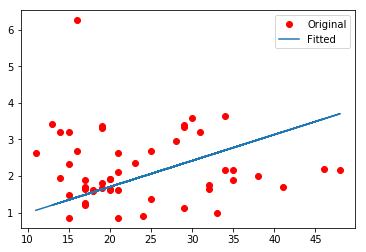

In [30]:
age_net = prepare_feature_numeric_column('housing_median_age')
income_net = prepare_feature_numeric_column('median_income')
a, b = make_regression(age_net, income_net)
make_plot(age_net, income_net)

Scaling is also a good try to improve the accuracy, but unfortunately not in this case...

Epoch: 0001 cost= 2.339301109 a= 0.07124789 b= 0.28071767
Epoch: 0200 cost= 1.723419905 a= 0.052291106 b= 0.62980056
Epoch: 0400 cost= 1.308138013 a= 0.036623683 b= 0.9171616
Epoch: 0600 cost= 1.029814601 a= 0.02374607 b= 1.1524099
Epoch: 0800 cost= 0.843282342 a= 0.0131615335 b= 1.3449951
Epoch: 1000 cost= 0.718267918 a= 0.0044617536 b= 1.502655
Epoch: 1200 cost= 0.634483397 a= -0.0026888868 b= 1.6317222
Epoch: 1400 cost= 0.578330398 a= -0.008566235 b= 1.7373837
Epoch: 1600 cost= 0.540696800 a= -0.01339702 b= 1.8238828
Epoch: 1800 cost= 0.515474379 a= -0.017367601 b= 1.8946959
Epoch: 2000 cost= 0.498570353 a= -0.020631172 b= 1.9526668
Epoch: 2200 cost= 0.487241387 a= -0.023313593 b= 2.0001237
Epoch: 2400 cost= 0.479648471 a= -0.025518367 b= 2.038975
Epoch: 2600 cost= 0.474559754 a= -0.027330546 b= 2.070781
Epoch: 2800 cost= 0.471149325 a= -0.028820042 b= 2.0968175
Epoch: 3000 cost= 0.468863577 a= -0.030044306 b= 2.1181335


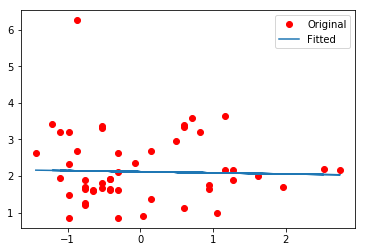

In [31]:
a, b = make_regression(net_age_scale, income_net)
make_plot(net_age_scale, income_net)

Bit of uniformity seems also not impressive in this case.

Epoch: 0001 cost= 0.475187421 a= -0.029784054 b= 2.1182868
Epoch: 0200 cost= 0.467562497 a= 0.0010577794 b= 2.139418
Epoch: 0400 cost= 0.466446757 a= 0.010067123 b= 2.1507013
Epoch: 0600 cost= 0.466131121 a= 0.011498497 b= 2.158404
Epoch: 0800 cost= 0.465922207 a= 0.010364664 b= 2.1647508
Epoch: 1000 cost= 0.465736777 a= 0.008395983 b= 2.1705115
Epoch: 1200 cost= 0.465564042 a= 0.0061886692 b= 2.175958
Epoch: 1400 cost= 0.465402305 a= 0.003947119 b= 2.1811867
Epoch: 1600 cost= 0.465250552 a= 0.0017404363 b= 2.1862333
Epoch: 1800 cost= 0.465108186 a= -0.00040892762 b= 2.1911163
Epoch: 2000 cost= 0.464974701 a= -0.002494746 b= 2.195844
Epoch: 2200 cost= 0.464849591 a= -0.004516208 b= 2.2004204
Epoch: 2400 cost= 0.464732200 a= -0.006474352 b= 2.2048526
Epoch: 2600 cost= 0.464622080 a= -0.00837084 b= 2.2091444
Epoch: 2800 cost= 0.464518845 a= -0.010207528 b= 2.2132998
Epoch: 3000 cost= 0.464422077 a= -0.011986282 b= 2.2173245


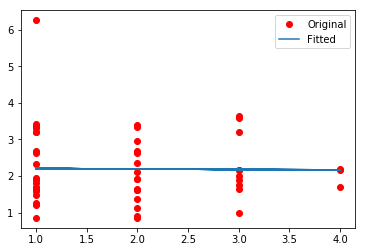

In [32]:
a, b = make_regression(bucket_index, income_net)
make_plot(bucket_index, income_net)